NOTE: if you are running this locally, the code here assumes that there are two folders ("stocks" and "etfs"), as well as a "symbols_valid_meta.csv" file. These will not be present if you download the repo, because I've added them to the gitignore. You will need to download the dataset yourself and move the files into this directory if you want to run all these cells yourself.


So, this is a NASDAQ dataset from kaggle, found here : https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset/data <br> Importantly, it's actually divided into three parts- a folder containing ETF data, a folder containing stock data, and a standalone csv containing metadata about symbols. The Stock and ETF data is organized into many CSV files by ticker, so our first priority will be collecting all of those individual CSVs into one file/dataframe for use. Also, as we'll see, almost all of the columns in the metadata are probably unhelpful- "market category", for instance, is more than half empty, as is "financial status" and "CQS symbol". "Security name" and "nasdaq traded" are also not worth keeping, since *all* of the securities are nasdaq traded, and name is just the name. "Listing exchange" could factor in, so we will be retrieving that though. Technically we could determine if a symbol is an ETF when we join everything together later, but it's probably easier to preserve it here. Lot size is also getting dropped- technically, there are 5 stocks which do have small lot sizes, but later we'll be removing thinly traded stocks anyway, so it's not overly relevant.

Size wise,this dataset is huge, with over 8000 symbols alone, and each symbol getting its own CSV file with daily quotes on the "Open"; "Close"; "High"; "Low"; "Volume"; "Adjusted Close"(The close price adjusted for any stock splits or dividends); and Date, for 7 columns. The number of rows varies pretty heavily in this- some of the tickers get quotes going all the way back to the 1960s, while some have 2020 as the oldest year with data available, which is a bit of a blessing in disguise as it gives a good way to cull some of the excess data. Additionally, I'm going to be culling thinly traded securities (>200000) traded a year, because conventional wisdom is that those stocks are more prone to rapid price swings.

In [106]:
# informational prints are commented out, but feel free to uncomment and run them to get a better idea of what the dataframe is like
import pandas as pd
import os
meta= "./symbols_valid_meta.csv"
symbol_meta= pd.read_csv(meta)
# print(symbol_meta.info())
# print(symbol_meta["Round Lot Size"].value_counts())
# small_lots=symbol_meta[symbol_meta["Round Lot Size"].isin([10.0, 1.0])==True]
# print("small", small_lots)
symbol_meta= symbol_meta.drop(["Nasdaq Traded","Security Name", "Round Lot Size", "CQS Symbol", "NextShares", "Financial Status", "Test Issue", "Market Category", "NASDAQ Symbol"],axis=1)
print(symbol_meta.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Symbol            8049 non-null   object
 1   Listing Exchange  8049 non-null   object
 2   ETF               8049 non-null   object
dtypes: object(3)
memory usage: 188.8+ KB
None


In the interest of being able to work with the data, I probably will need to cut out a few years, going to opt for 2010-2020 for a round 10 year gap, as opposed to the 15 year one given by default. There isn't a quantitative justification for this, it's just really impractical to wait so log just to run simple loading. The 251 offset for last year price is because there are 251 trading days on the stock market, and since we then truncate the dates anyway the missing values are trimmed (every stock has data goi)

In [110]:
import glob
stock_path= "./stocks"
etf_path= "./etfs"
stock_filepaths= list(glob.iglob("./stocks/*csv"))
etf_filepaths= list(glob.iglob("./etfs/*csv"))
files= stock_filepaths+etf_filepaths
# Had to look up how to do joins in pandas on stack exchange lol
all_securities= []
smallest_date=pd.to_datetime('2099-01-01')
for file in files:
    # This will always be a string beginning with './stocks' and ending with '.csv', so we can just slice to remove those and get the ticker
    ticker= file[9:][:-4]
    df= pd.read_csv(file)
    # this will be useful later to join each symbol with its metadata
    df["Symbol"]=ticker
    # normalize date
    df["Date"]= pd.to_datetime(df["Date"])
    df["Year"]= df["Date"].dt.year

    df["volume_year"] = df.groupby(["Symbol", "Year"])[["Adj Close"]].transform("sum")

    min_date= pd.to_datetime("2010-01-01")
    # if there isn't at least 10 years of data discard it, and if there are more than 10 years we only keep the 10 from 2010-2020
    if df["Date"].min()<min_date:
        continue
# nasdaq defines a thinly traded stock as having less than 100000 in the last 6 months, so we'll just approach it this way to keep it simple
    elif df["volume_year"].min()<200000:
        continue
    else:
        df["prev_year_price"]= df["Adj Close"].shift(-251)
        df["YTD returns"]= (df["Adj Close"]/df["prev_year_price"]-1)*100
        df.drop("prev_year_price", axis=1)
        only_past_2010= df[df["Date"].dt.year>=2010]

        all_securities.append(only_past_2010)



This next bit of code is to bring all the csv files together into a single dataframe, including joining the metadata info onto the symbols.

This actually turned out to be a bit trickier than I thought, because the CSV files don't store their symbols anywhere, they're just named after the ticker they are data for, so needed to do some extra work to add those back in order to join it properly with the meta stock data.

In [81]:
all_securities=pd.concat(all_securities)

merged_with_meta= pd.merge(all_securities, symbol_meta, on="Symbol", how= "inner")

As you can see, we've got all the columns joined together nicely now, and the dataset is reasonably(?) cleaned up and ready for processing.

In [ ]:
print(merged_with_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3515911 entries, 0 to 3515910
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   Open              float64       
 2   High              float64       
 3   Low               float64       
 4   Close             float64       
 5   Adj Close         float64       
 6   Volume            float64       
 7   Symbol            object        
 8   prev_year_price   float64       
 9   YTD returns       float64       
 10  Listing Exchange  object        
 11  ETF               object        
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 321.9+ MB
None


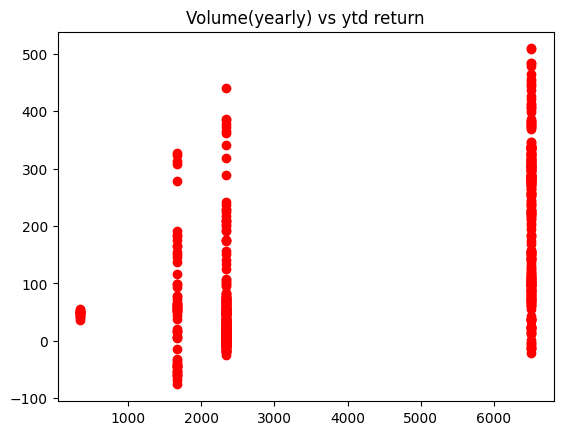

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(merged_with_meta["volume_year"], merged_with_meta["YTD returns"], c="red")
plt.title("Volume(yearly) vs ytd return")
plt.xlabel= "Volume"
plt.ylabel= "return(ytd)"
plt.show()



It seems to be at least somewhat correlated- the upper end of returns seems to sit on the highest volume bracket.

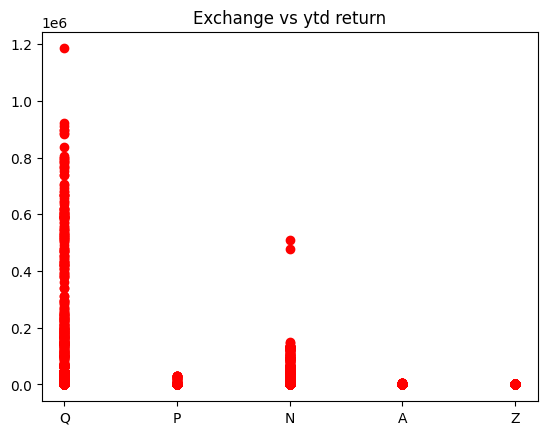

In [98]:
import matplotlib.pyplot as plt
plt.scatter(merged_with_meta["Listing Exchange"], merged_with_meta["YTD returns"], c="red")
plt.title("Exchange vs ytd return")
plt.xlabel= "Exchange"
plt.ylabel= "return(ytd)"
plt.show()



Seems like it might be worth keeping around at least maybe? If I knew what those symbols stood for I'd probably have more insight, but nothing in the dataset explains it, although speculatively different exchanges prioritize different things- NASDAQ is famously quite tech heavy, for instance.

In [112]:
merged_with_meta.corr(method='pearson',numeric_only=True)

,Open,High,Low,Close,Adj Close,Volume,prev_year_price,YTD returns
Open,1.000000,0.998837,0.999166,0.997667,0.997667,-0.001956,0.702898,0.004818
High,0.998837,1.000000,0.998694,0.998908,0.998908,-0.001955,0.692174,0.004856
Low,0.999166,0.998694,1.000000,0.998898,0.998898,-0.001960,0.708087,0.004808
Close,0.997667,0.998908,0.998898,1.000000,1.000000,-0.001957,0.699936,0.004835
Adj Close,0.997667,0.998908,0.998898,1.000000,1.000000,-0.001957,0.699936,0.004834
Volume,-0.001956,-0.001955,-0.001960,-0.001957,-0.001957,1.000000,-0.001479,-0.003444
prev_year_price,0.702898,0.692174,0.708087,0.699936,0.699936,-0.001479,1.000000,0.000471
YTD returns,0.004818,0.004856,0.004808,0.004835,0.004834,-0.003444,0.000471,1.000000


So, this result isn't actually super surprising- The 5 highly correlated variables are all essentially measures of the same thing (the stock price during a given day). Generally speaking, most stocks don't make wild swings during trading hours- there's some interesting literature on this if you want to read about it (https://www.sciencedirect.com/science/article/abs/pii/S1057521922001892) is a good place to start, but the short version is that most of the really big price moving information (earnings, etc) tends to come out while the markets are closed, so the really big gaps tend to be prev days close-> next open. This is also exacerbated a little by the fact that there is still limited trading after hours, meaning that those small amounts of stock that still are traded are more vulnerable to large price swings. As such, it makes intuitive sense that prices don't change much during a day, and since we have many measures of prices during the day, we're going to have many correlated variables.

Given how incredibly closely correlated Open, high, low, Close, and adj Close are, I will opt to drop all but adj close (since I base the Year adjustments off of it and keeping it would keep it consistent)

In [ ]:
merged_with_meta.drop(["Open", "Close", "High", "Low"], axis=1)

,Date,Adj Close,Volume,Symbol,prev_year_price,YTD returns,Listing Exchange,ETF
0,2014-03-28,13.98,9465500.0,TWOU,22.490000,-37.839041,Q,N
1,2014-03-31,13.65,561000.0,TWOU,23.950001,-43.006266,Q,N
2,2014-04-01,14.06,467300.0,TWOU,25.580000,-45.035182,Q,N
3,2014-04-02,15.61,592100.0,TWOU,25.520000,-38.832291,Q,N
4,2014-04-03,14.15,485200.0,TWOU,25.400000,-44.291339,Q,N
...,...,...,...,...,...,...,...,...
3515906,2020-03-26,12.39,3399100.0,T,NaN,NaN,N,N
3515907,2020-03-27,13.95,4215200.0,T,NaN,NaN,N,N
3515908,2020-03-30,14.70,4937300.0,T,NaN,NaN,N,N
3515909,2020-03-31,14.68,3484300.0,T,NaN,NaN,N,N


The last thing to do now is actually save this as a csv, so we can use it in the main python file with pytorch

JUST KIDDING I forgot to make a benchmark to train x against, so we'll add YTD earnings>10 for our y_train/test value later

In [ ]:
merged_with_meta["Beats_spy"]= merged_with_meta["YTD returns"]>10

Beats_spy
False    2535727
True      980184
Name: count, dtype: int64


In [116]:
merged_with_meta.to_csv("Cleaned_data.csv")